## Exploratory Data Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import opensmile
import librosa
import os
import time
import audb
import audiofile
import IPython

In [2]:
# Load sample audio file
file_path = "./data_folder/angry/YAF_merge_angry.wav"
IPython.display.Audio(file_path)

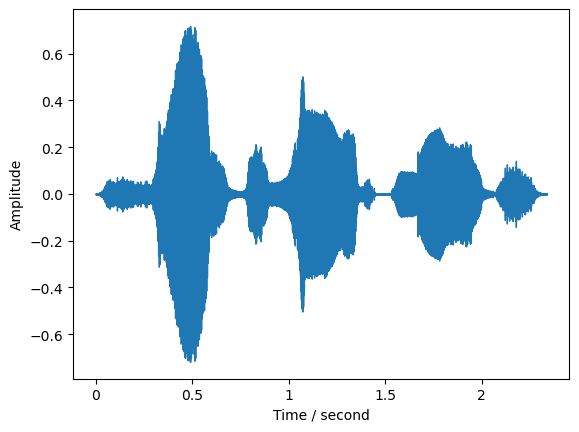

In [3]:
signal, sample_rate = librosa.load("./data_folder/angry/YAF_merge_angry.wav")

# Show amplitude
plt.figure(1)
librosa.display.waveshow(y=signal, sr=sample_rate)
plt.xlabel('Time / second')
plt.ylabel('Amplitude')
plt.show()

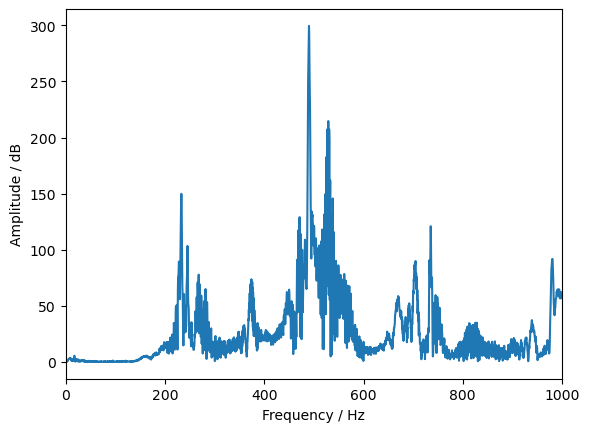

In [4]:
# Analyze frequency/amplitude
k = np.arange(len(signal))
T = len(signal)/sample_rate
freq = k/T

DATA_0 = np.fft.fft(signal)
abs_DATA_0 = abs(DATA_0)
plt.figure(2)
plt.plot(freq, abs_DATA_0)
plt.xlabel("Frequency / Hz")
plt.ylabel("Amplitude / dB")
plt.xlim([0, 1000])
plt.show()

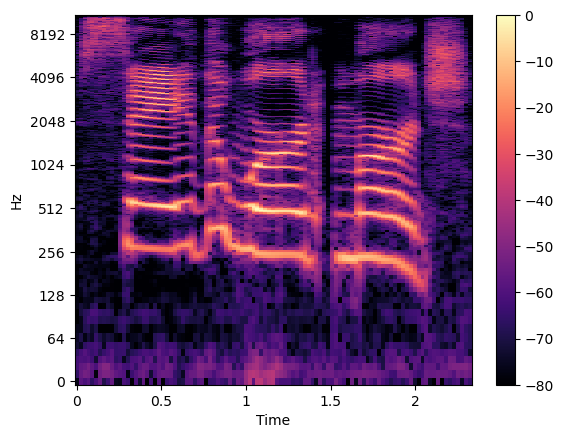

In [5]:
# Time vs frequency variation
D = librosa.stft(signal)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
plt.figure(3)
librosa.display.specshow(S_db, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

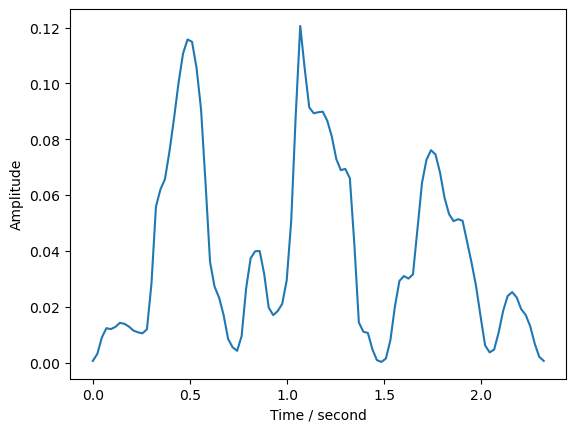

In [6]:
# Analyze loudness
df_loudness = pd.DataFrame()
S, phase = librosa.magphase(librosa.stft(signal))
rms = librosa.feature.rms(S=S)
df_loudness['Loudness'] = rms[0]
plt.figure(4)
times = librosa.times_like(rms)
plt.plot(times, rms[0])
plt.xlabel("Time / second")
plt.ylabel("Amplitude")
plt.show()

## Feature Extractions

### Acoustic Feature Extraction

In [7]:
# Acoustic Feature Extraction
def acoustic_extraction(file_path):
    signal, sampling_rate = audiofile.read(file_path)

    # Set up feature extractor for low-level descriptors
    smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.LowLevelDescriptors,
    )

    # Process Signal
    df = smile.process_signal(
        signal,
        sampling_rate
    )
    return df

### Feature Post-Processing

In [8]:
# Feature Post-Processing
def normalize(df):
    for col in df.columns:
        df[col] = (df[col]-df[col].min())/(df[col].max()-df[col].min())
    return df

def compute_feature_vector(df):
    #df = normalize(df)
    avg_list = []
    row_num = df.shape[0]
    #print(row_num)
    for col in df.columns:
        total = df[col].sum()
        avg_list.append(total/row_num)
    
    return avg_list

In [9]:
# Returns feature vector and column names
def feature_extraction_file(file_path):
    df = acoustic_extraction(file_path)
    return compute_feature_vector(df), df.columns

### Processing Files

In [10]:
# Gets all relative file paths for each emotion folders
# Example: get_all_files('./data_folder/angry')
def get_all_files(folder_path):
    file_path = []
    file_names = os.listdir(path=folder_path)
    for name in file_names:
        file_path.append(folder_path+'/'+name)
    return file_path

In [11]:
def extract_feature(folder_path, emotion):
    folder_path += '/'+emotion
    file_path = get_all_files(folder_path)
    
    vector_list = []
    for path in file_path:
        feature_vector, column_names = feature_extraction_file(path)
        vector_list.append(feature_vector)
    df = pd.DataFrame(vector_list)
    df.columns = column_names
    # Labels angry as 0, fear as 1, happy as 2, and sad as 3
    emotion_to_num = {'angry': 0, 'fear': 1, 'happy': 2, 'sad': 3}
    df['emotion']=emotion_to_num[emotion]
    
    return df

In [12]:
from sklearn.utils import shuffle

def read_data(folder_path):
    print('processing angry folder...')
    df_angry = extract_feature('./data_folder', "angry")
    print('processing fear folder...')
    df_fear = extract_feature('./data_folder', 'fear')
    print('processing happy folder...')
    df_happy = extract_feature('./data_folder', 'happy')
    print('processing sad folder...')
    df_sad = extract_feature('./data_folder', 'sad')
    
    df = pd.concat([df_angry, df_fear, df_happy, df_sad]).reset_index(drop=True)
    df = shuffle(df).reset_index(drop=True)
    return df

In [13]:
df = read_data('./data_folder')
df

processing angry folder...
processing fear folder...
processing happy folder...
processing sad folder...


,Loudness_sma3,alphaRatio_sma3,hammarbergIndex_sma3,slope0-500_sma3,slope500-1500_sma3,spectralFlux_sma3,mfcc1_sma3,mfcc2_sma3,mfcc3_sma3,mfcc4_sma3,...,F1frequency_sma3nz,F1bandwidth_sma3nz,F1amplitudeLogRelF0_sma3nz,F2frequency_sma3nz,F2bandwidth_sma3nz,F2amplitudeLogRelF0_sma3nz,F3frequency_sma3nz,F3bandwidth_sma3nz,F3amplitudeLogRelF0_sma3nz,emotion
0,1.246246,-8.547600,16.338467,0.079916,-0.017749,0.428959,12.175686,-6.733304,2.720721,-22.517450,...,690.381762,851.168311,-24.945569,1646.839181,931.209978,-29.947080,2806.735015,671.912875,-34.463259,2
1,0.775937,-4.078068,13.323279,0.057340,-0.012052,0.296465,6.388894,3.358065,-1.700562,-21.253293,...,684.364070,878.903868,-72.828134,1692.564462,708.219731,-81.162626,2899.746637,774.087864,-82.586025,0
2,0.730140,-4.817553,12.837771,0.057303,-0.011479,0.312939,6.517753,-0.258135,5.373849,-12.525281,...,750.947633,944.418466,-84.377912,1746.318939,767.332860,-89.180824,2894.889394,632.699148,-91.347976,1
3,0.574217,-15.102488,24.564855,0.012553,-0.027302,0.182337,20.128279,17.737177,10.145322,-8.221207,...,605.235789,1218.726810,-76.491039,1649.909502,904.858597,-88.422317,2676.739819,810.503252,-92.273729,3
4,0.833749,-0.330520,7.646162,0.062304,-0.015029,0.337931,1.841808,6.121644,1.715850,-22.153373,...,750.285976,940.553125,-64.065139,1794.457927,762.021189,-68.195922,2992.662195,877.569207,-68.358337,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.519932,-17.671249,24.904936,0.033801,-0.033550,0.133056,20.764750,20.682196,14.679657,-14.110578,...,563.937225,1097.049972,-48.167315,1745.212004,721.334320,-65.253196,2800.158040,606.364537,-65.486066,3
396,0.404040,-16.020121,24.606889,0.019331,-0.024918,0.201745,18.902613,17.734633,14.172952,-5.549729,...,586.534045,1096.656178,-83.222495,1686.767489,758.918578,-94.515715,2706.397936,684.098839,-95.861902,3
397,0.858285,-4.735814,12.758128,0.061249,-0.018881,0.331906,4.171876,6.864389,-1.877494,-24.138255,...,729.620986,902.041284,-79.939381,1819.125143,721.017489,-83.700563,2956.190367,725.188145,-85.921678,0
398,0.862617,-5.739200,14.630682,0.077860,-0.018683,0.326311,11.800968,-1.054334,2.685322,-27.812288,...,658.460870,917.558016,-41.694455,1736.950272,701.656114,-48.527161,2932.766304,801.038519,-49.509311,0


## Train Audio Recognition Model

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [15]:
# Split data
X = df.iloc[:, :25]
y = df['emotion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=1, stratify=y)

In [16]:
dtree = DecisionTreeClassifier().fit(X_train, y_train)
prediction_dtree = dtree.predict(X_test)
print(classification_report(y_test, prediction_dtree))

              precision    recall  f1-score   support

           0       0.85      0.77      0.81        30
           1       0.80      0.80      0.80        30
           2       0.79      0.87      0.83        30
           3       1.00      1.00      1.00        30

    accuracy                           0.86       120
   macro avg       0.86      0.86      0.86       120
weighted avg       0.86      0.86      0.86       120



In [17]:
svm = SVC(kernel = 'linear').fit(X_train, y_train)
prediction_svm = svm.predict(X_test)
print(classification_report(y_test, prediction_svm))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        30
           1       1.00      1.00      1.00        30
           2       0.97      1.00      0.98        30
           3       1.00      1.00      1.00        30

    accuracy                           0.99       120
   macro avg       0.99      0.99      0.99       120
weighted avg       0.99      0.99      0.99       120



In [18]:
knn = KNeighborsClassifier(n_neighbors = 7).fit(X_train, y_train)
prediction_knn = knn.predict(X_test)
print(classification_report(y_test, prediction_knn))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94        30
           1       0.70      0.77      0.73        30
           2       0.79      0.50      0.61        30
           3       0.88      1.00      0.94        30

    accuracy                           0.82       120
   macro avg       0.81      0.82      0.80       120
weighted avg       0.81      0.82      0.80       120

